In [1]:
import tidy3d as td
from tidy3d_backend.run_heat import run_heat_sim
import matplotlib.pyplot as plt
import numpy as np

In [2]:
ni = 1e19
semiconductor=td.MultiPhysicsMedium(charge=td.SemiconductorMedium(
    permittivity=1,
    N_d=0,
    N_a=0,
    N_c=ni,
    N_v=ni,
    E_g=1e-18,
    mobility_n=td.ConstantMobilityModel(mu=1),
    mobility_p=td.ConstantMobilityModel(mu=1),
    R=[],
    delta_E_g=None),
    name="semiconductor"
)
air = td.Medium(heat_spec=td.FluidSpec(), name="air")

# define structures
structure = td.Structure(
    geometry=td.Box(center=(0, 0, 0), size=(2, 2, 2)), medium=semiconductor, name="structure"
)

structure_bc1 = td.Structure(
    geometry=td.Box.from_bounds(rmin=(-2, -2, -2), rmax=(0, 2, 2)), medium=air, name="structure_bc1"
)
structure_bc2 = td.Structure(
    geometry=td.Box.from_bounds(rmin=(0, -2, -2), rmax=(2, 2, 2)), medium=air, name="structure_bc2"
)

voltage_bc =  td.HeatChargeBoundarySpec(
    condition=td.VoltageBC(source=td.DCVoltageSource(voltage=0)),
    placement=td.StructureStructureInterface(structures=[structure.name, structure_bc1.name]),
)

voltage_bc2 =  td.HeatChargeBoundarySpec(
    condition=td.VoltageBC(source=td.DCVoltageSource(voltage=0)),
    placement=td.StructureStructureInterface(structures=[structure.name, structure_bc2.name]),
)

In [3]:
def create_run_simulation(dl = 0.5):
    simulation = td.HeatChargeSimulation(
        size=(3, 3, 0),
        center=(0, 0, 0),
        structures=[structure_bc1, structure_bc2, structure],
        medium=air,
        monitors=[
            td.SteadyPotentialMonitor(center=(0, 0, 0), size=(td.inf, td.inf, 0), name="potential_global_mnt", unstructured=True),
            td.SteadyFreeCarrierMonitor(center=(0, 0, 0), size=(td.inf, td.inf, 0), name="charge_global_mnt", unstructured=True),
        ],
        boundary_spec=[voltage_bc, voltage_bc2],
        grid_spec=td.UniformUnstructuredGrid(dl=dl, relative_min_dl=0),
        analysis_spec=td.IsothermalSteadyChargeDCAnalysis(
            temperature=300,
            convergence_dv=0.1,
            # tolerance_settings=td.ChargeToleranceSpec(rel_tol=1e-4, abs_tol=1e18, max_iters=400, ramp_up_iters=1)
            # tolerance_settings=td.ChargeToleranceSpec(rel_tol=1e-7, abs_tol=1e18, max_iters=400, ramp_up_iters=1)
            tolerance_settings=td.ChargeToleranceSpec(rel_tol=dl*dl, abs_tol=1e18, max_iters=400, ramp_up_iters=1)
        ),
    )
    
    # plot simulation
    # fig, ax = plt.subplots(1, 2, figsize=(10, 15))
    # simulation.plot(z=0, ax=ax[0])
    # simulation.plot_property(z=0, property="electric_conductivity", ax=ax[1])
    # plt.tight_layout()
    # plt.show()

    sim_results = run_heat_sim(sim=simulation, charge_mms=True)

    # sim_results["potential_global_mnt"].potential.sel(voltage=0).plot()
    # sim_results["charge_global_mnt"].electrons.sel(voltage=0).plot()
    # sim_results["charge_global_mnt"].holes.sel(voltage=0).plot()

    # ERROR CALCULATION
    # exact solution - phi
    a = 0.5
    X = np.linspace(-1, 1, 1000)
    Y = np.linspace(-1, 1, 1000)
    Xmesh, Ymesh = np.meshgrid(X, Y, indexing='ij')
    values = a*(Xmesh*Xmesh - 1)*(Ymesh*Ymesh - 1)
    exact_solution = td.SpatialDataArray(data=values, coords=dict(x=X, y=Y))
    
    # interpo solution - phi
    interp_sol = sim_results["potential_global_mnt"].potential.sel(voltage=0).interp(x=X, y=Y, z=0, fill_value="extrapolate")
    diff = np.abs(interp_sol - exact_solution)
    diff.plot()
    plt.show()
    error_phi = np.mean(diff.data)/a
    
    # exact solution - n
    X = np.linspace(-1, 1, 1000)
    Y = np.linspace(-1, 1, 1000)
    Xmesh, Ymesh = np.meshgrid(X, Y, indexing='ij')
    values = ni*np.exp(a*(Xmesh*Xmesh - 1)*(Ymesh*Ymesh - 1))
    exact_solution = td.SpatialDataArray(data=values, coords=dict(x=X, y=Y))
    
    # interpo solution - n
    interp_sol = sim_results["charge_global_mnt"].electrons.sel(voltage=0).interp(x=X, y=Y, z=0, fill_value="extrapolate")
    diff = np.abs(interp_sol - exact_solution)/ni
    diff.plot()
    plt.show()
    error_n = np.mean(diff.data)
    
    # interpo solution - p
    interp_sol = sim_results["charge_global_mnt"].holes.sel(voltage=0).interp(x=X, y=Y, z=0, fill_value="extrapolate")
    diff = np.abs(interp_sol - exact_solution)/ni
    diff.plot()
    plt.show()
    
    error_p = np.mean(diff.data)
    return error_phi, error_n, error_p

Resetting DEVSIM
Physical group name bc_0 has 0 Tetrahedra.
Physical group name bc_0 has 0 Triangles.
Physical group name bc_0 has 20 Lines.
Physical group name bc_0 has 20 Points.
Physical group name zone_1 has 0 Tetrahedra.
Physical group name zone_1 has 100 Triangles.
Physical group name zone_1 has 160 Lines.
Physical group name zone_1 has 61 Points.
Device device has 61 coordinates with max index 61
Region zone_1 has 61 nodes.
Contact zone_1_bc_0 in region zone_1 with 20 nodes
Region: zone_1, Equation: PotentialEquation, Variable: Potential
[25-04-16 09:57:10.259][USER   ]: Ramping up doping. Scaling  by 1.0                                
Replacing Node Model NetDoping in region zone_1 of material Si
Replacing Node Model n_i in region zone_1 of material Si
Replacing Edge Model n_i@n0 in region zone_1 of material Si
Replacing Edge Model n_i@n1 in region zone_1 of material Si
Replacing Node Model zone_1_bc_0nodeelectrons in region zone_1 of material Si
Replacing Node Model zone_1_bc

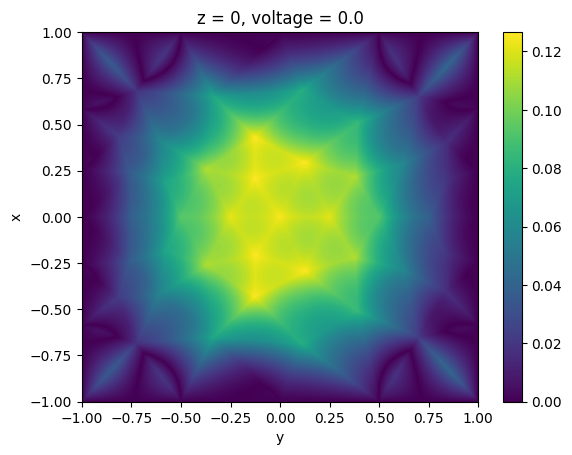

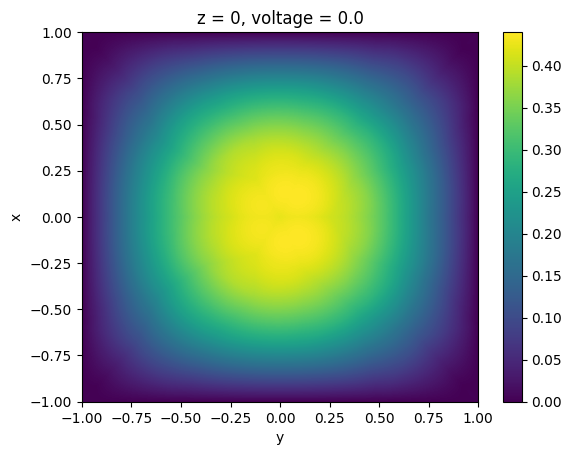

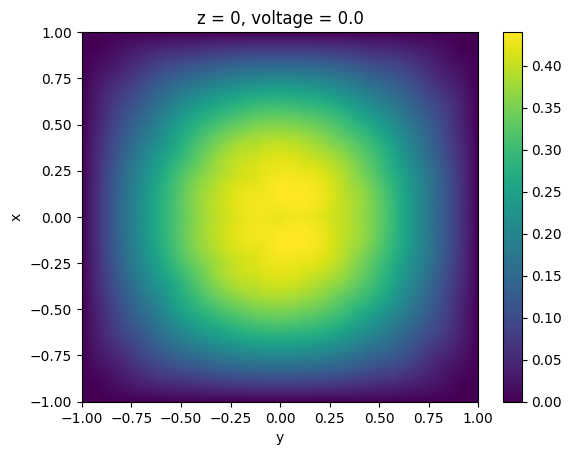

Resetting DEVSIM
Physical group name bc_0 has 0 Tetrahedra.
Physical group name bc_0 has 0 Triangles.
Physical group name bc_0 has 54 Lines.
Physical group name bc_0 has 54 Points.
Physical group name zone_1 has 0 Tetrahedra.
Physical group name zone_1 has 452 Triangles.
Physical group name zone_1 has 705 Lines.
Physical group name zone_1 has 254 Points.
Device device has 254 coordinates with max index 254
Region zone_1 has 254 nodes.
Contact zone_1_bc_0 in region zone_1 with 54 nodes
Region: zone_1, Equation: PotentialEquation, Variable: Potential
[25-04-16 09:57:16.418][USER   ]: Ramping up doping. Scaling  by 1.0                                
Replacing Node Model NetDoping in region zone_1 of material Si
Replacing Node Model n_i in region zone_1 of material Si
Replacing Edge Model n_i@n0 in region zone_1 of material Si
Replacing Edge Model n_i@n1 in region zone_1 of material Si
Replacing Node Model zone_1_bc_0nodeelectrons in region zone_1 of material Si
Replacing Node Model zone_

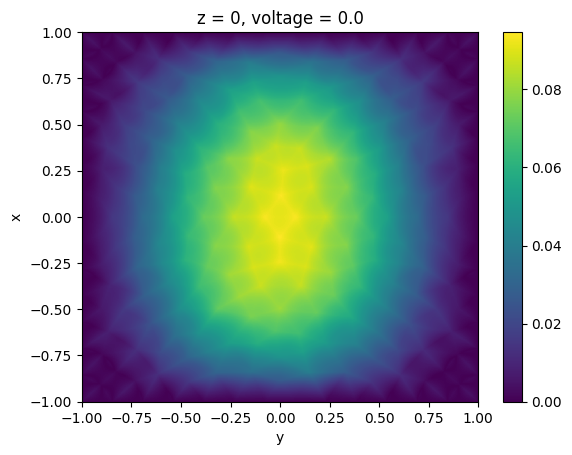

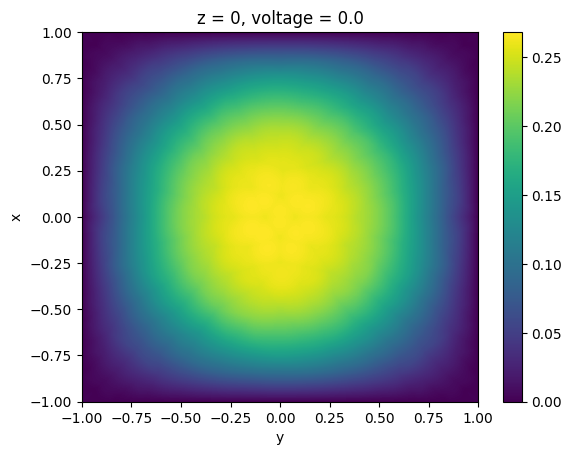

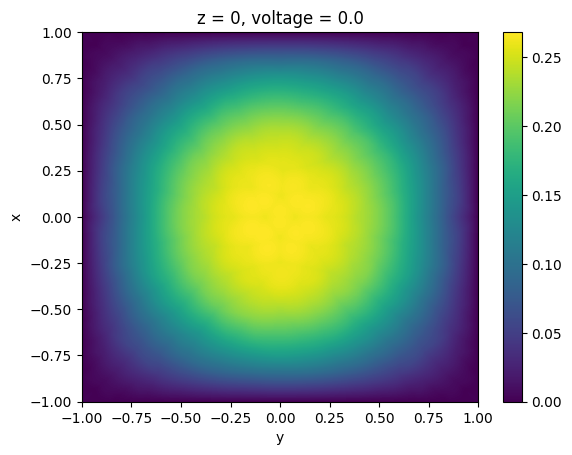

Resetting DEVSIM
Physical group name bc_0 has 0 Tetrahedra.
Physical group name bc_0 has 0 Triangles.
Physical group name bc_0 has 160 Lines.
Physical group name bc_0 has 160 Points.
Physical group name zone_1 has 0 Tetrahedra.
Physical group name zone_1 has 4236 Triangles.
Physical group name zone_1 has 6434 Lines.
Physical group name zone_1 has 2199 Points.
Device device has 2199 coordinates with max index 2199
Region zone_1 has 2199 nodes.
Contact zone_1_bc_0 in region zone_1 with 160 nodes
Region: zone_1, Equation: PotentialEquation, Variable: Potential
[25-04-16 09:57:22.688][USER   ]: Ramping up doping. Scaling  by 1.0                                
Replacing Node Model NetDoping in region zone_1 of material Si
Replacing Node Model n_i in region zone_1 of material Si
Replacing Edge Model n_i@n0 in region zone_1 of material Si
Replacing Edge Model n_i@n1 in region zone_1 of material Si
Replacing Node Model zone_1_bc_0nodeelectrons in region zone_1 of material Si
Replacing Node Mo

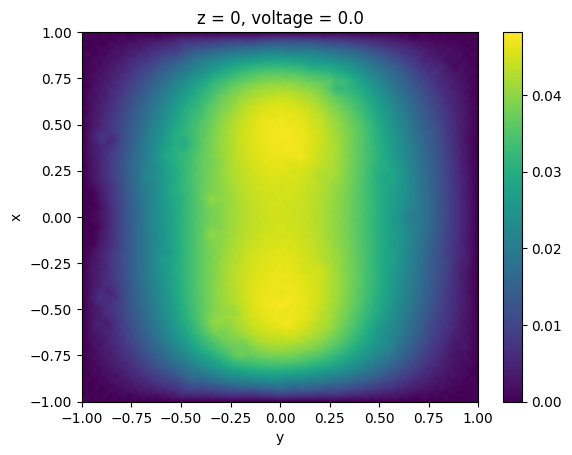

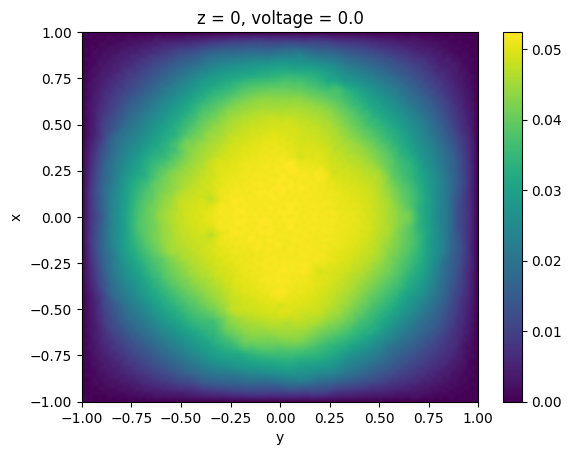

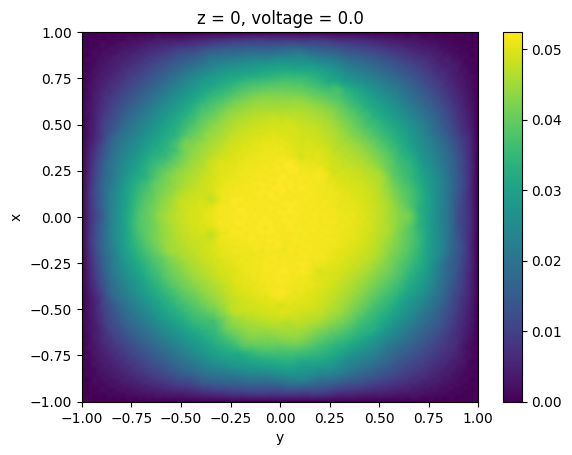

[25-04-16 09:57:28.340][USER   ]: WARNING: WARNING: It has been estimated the mesh to be bigger than
[25-04-16 09:57:28.340][USER   ]: the currently supported mesh size for Charge simulations. The     
[25-04-16 09:57:28.340][USER   ]: simulation may be submitted but if the maximum number of nodes is 
[25-04-16 09:57:28.340][USER   ]: indeed exceeded the pipeline will be stopped. If this happens the 
[25-04-16 09:57:28.340][USER   ]: grid specification may need to be modified.                       
[25-04-16 09:57:28.366][USER   ]: WARNING: WARNING: It has been estimated the mesh to be bigger than
[25-04-16 09:57:28.366][USER   ]: the currently supported mesh size for Charge simulations. The     
[25-04-16 09:57:28.366][USER   ]: simulation may be submitted but if the maximum number of nodes is 
[25-04-16 09:57:28.366][USER   ]: indeed exceeded the pipeline will be stopped. If this happens the 
[25-04-16 09:57:28.366][USER   ]: grid specification may need to be modified.              

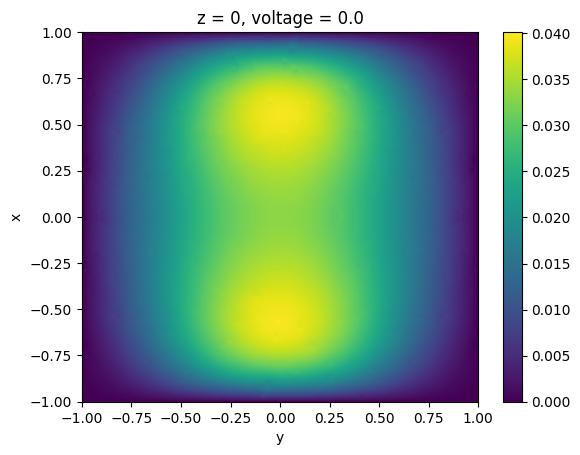

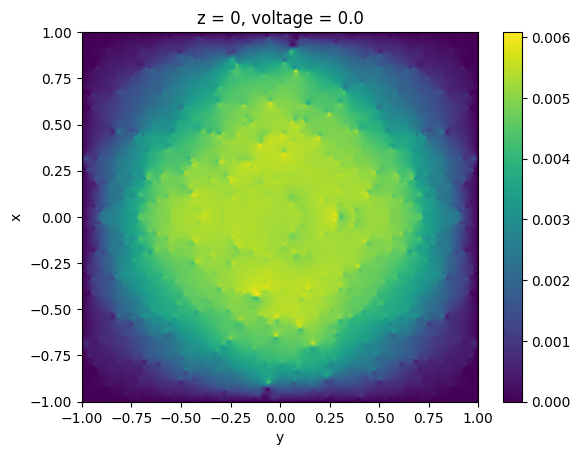

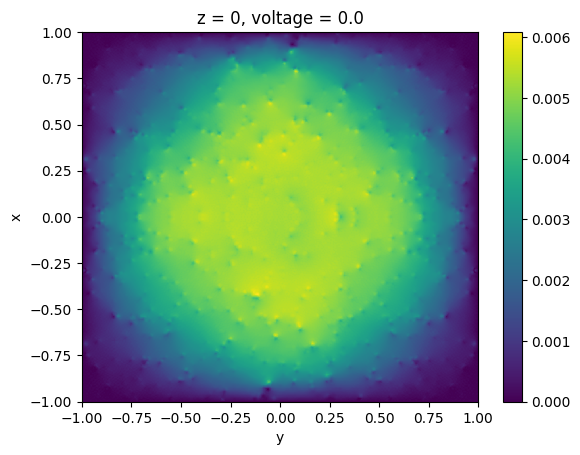

[25-04-16 09:57:44.702][USER   ]: WARNING: WARNING: It has been estimated the mesh to be bigger than
[25-04-16 09:57:44.702][USER   ]: the currently supported mesh size for Charge simulations. The     
[25-04-16 09:57:44.702][USER   ]: simulation may be submitted but if the maximum number of nodes is 
[25-04-16 09:57:44.702][USER   ]: indeed exceeded the pipeline will be stopped. If this happens the 
[25-04-16 09:57:44.702][USER   ]: grid specification may need to be modified.                       
[25-04-16 09:57:44.726][USER   ]: WARNING: WARNING: It has been estimated the mesh to be bigger than
[25-04-16 09:57:44.726][USER   ]: the currently supported mesh size for Charge simulations. The     
[25-04-16 09:57:44.726][USER   ]: simulation may be submitted but if the maximum number of nodes is 
[25-04-16 09:57:44.726][USER   ]: indeed exceeded the pipeline will be stopped. If this happens the 
[25-04-16 09:57:44.726][USER   ]: grid specification may need to be modified.              

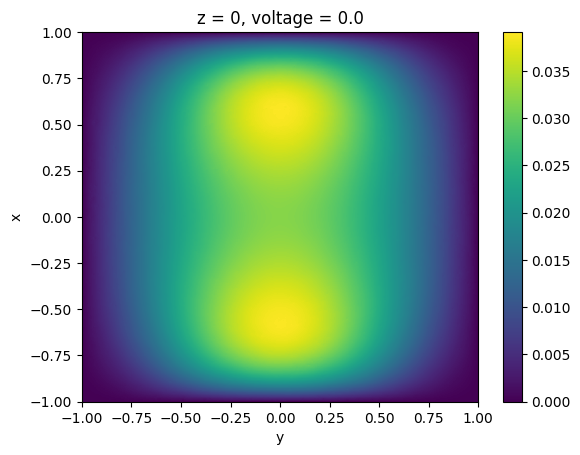

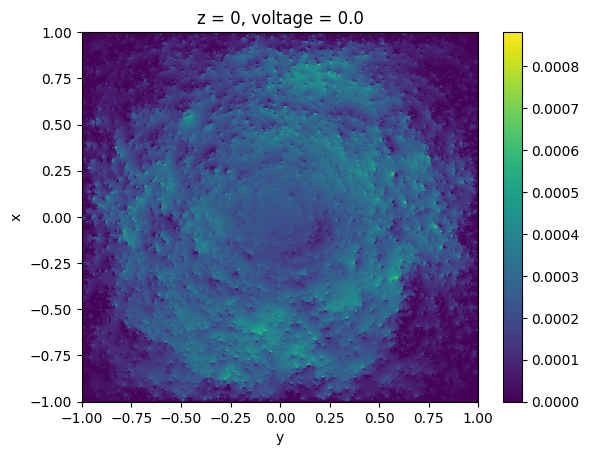

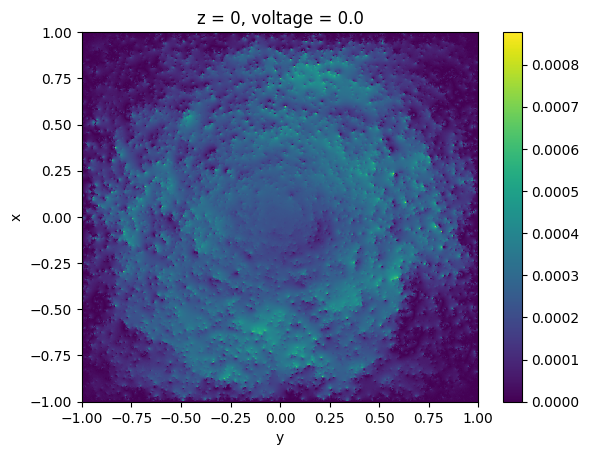

In [4]:
errors = dict(phi=[], n=[], p=[])
dls = 0.5*np.logspace(0, -2, num=5)
for dl in dls:
    err_phi, err_n, err_p = create_run_simulation(dl)
    errors["phi"].append(err_phi)
    errors["n"].append(err_n)
    errors["p"].append(err_p)

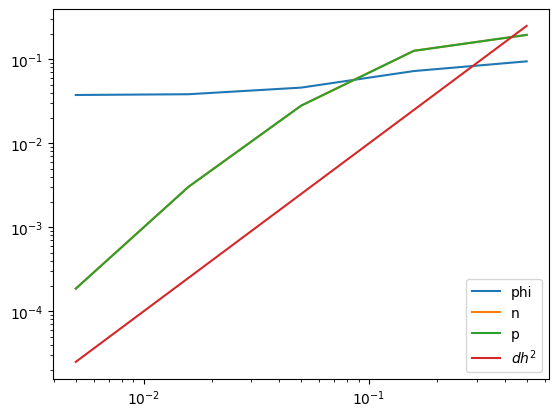

In [5]:
plt.loglog(dls, errors["phi"], label="phi")
plt.loglog(dls, errors["n"], label="n")
plt.plot(dls, errors["p"], label="p")
plt.loglog(dls, dls*dls, label="$dh^2$")
plt.legend()
plt.show()